In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


In [2]:
from tightening_project.cache import CacheArtifact
from tightening_project.data.loader import TighteningLoader
from tightening_project.config import find_latest_csv
from tightening_project.data.cleaning import clean_tightening_df

cache = CacheArtifact(app_name="tightening_project")
loader = TighteningLoader(cache)

csv_path = find_latest_csv()
res = loader.load_csv_cached(csv_path)
df_raw = res.df

df, report = clean_tightening_df(df_raw)
print(report)
print("Shape:", df.shape)


C:\Users\ngher\Desktop\analisis\tightening_project\src\tightening_project\data\cleaning.py:135: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d2[datetime_col] = pd.to_datetime(d2[datetime_col], errors="coerce", utc=True)


CleaningReport(rows_in=23486, rows_out=23486, datetime_parsed=True, fixed_torque_rows=3568, fixed_angle_rows=0, dropped_rows_missing_essentials=0)
Shape: (23486, 23)


In [3]:
PROCESS_COLS = [
    "PS_Number",
    "Tool_ID",
    "TorqueTarget"
    
]

missing = [c for c in PROCESS_COLS if c not in df.columns]
missing


[]

In [4]:
process_counts = (
    df
    .groupby(PROCESS_COLS)
    .size()
    .reset_index(name="n")
    .sort_values("n")
)

print("Número de procesos:", len(process_counts))
process_counts.head(10)


Número de procesos: 231


,PS_Number,Tool_ID,TorqueTarget,n
8,1,81123693,0.4,1
28,2,81123704,0.5,1
62,4,81123583,0.0,1
35,2,81123737,0.0,1
49,3,81123693,0.0,1
50,3,81123693,0.8,1
124,7,81123594,0.0,1
177,20,811235252,0.0,1
163,16,811236666,0.0,1
173,19,811236565,0.0,1


In [5]:
MIN_N = 25

valid_processes = process_counts[process_counts["n"] >= MIN_N]

df_spc = df.merge(valid_processes[PROCESS_COLS], on=PROCESS_COLS, how="inner")

print("Procesos válidos:", len(valid_processes))
print("Filas SPC:", df_spc.shape)


Procesos válidos: 129
Filas SPC: (22424, 23)


In [6]:
df_spc["torque_error"] = df_spc["RES_FinalTorque"] - df_spc["TorqueTarget"]


In [7]:
spc_stats = (
    df_spc
    .groupby(PROCESS_COLS)
    .agg(
        torque_target=("TorqueTarget", "first"),
        torque_min_tol=("TorqueMinTolerance", "first"),
        torque_max_tol=("TorqueMaxTolerance", "first"),
        n=("torque_error", "size"),
        mean_error=("torque_error", "mean"),
        std_error=("torque_error", "std"),
        min_error=("torque_error", "min"),
        max_error=("torque_error", "max"),

        # Especificación (constante por proceso)
    )
    .sort_values("std_error", ascending=False)
)

spc_stats.head(10)


,,,torque_target,torque_min_tol,torque_max_tol,n,mean_error,std_error,min_error,max_error
PS_Number,Tool_ID,TorqueTarget,,,,,,,,
3,81123605,45.0,45.0,44.5,49.5,32,10.130000,20.622383,-34.18,54.89
6,81123605,45.0,45.0,44.5,48.0,42,3.255952,15.613260,-33.64,51.52
3,81123616,45.0,45.0,44.5,49.5,30,1.033667,13.798620,-33.43,54.77
30,811235454,14.0,14.0,13.0,15.0,29,2.613103,13.762464,-0.03,74.17
2,81123616,80.0,80.0,79.5,88.0,82,1.432439,13.345710,-66.12,14.65
6,81123616,45.0,45.0,44.5,48.0,37,0.986216,13.307997,-33.31,49.73
2,81123638,80.0,80.0,79.5,88.0,133,0.927368,13.059424,-69.46,18.16
3,81123638,45.0,45.0,44.5,49.5,47,1.251489,12.994926,-34.78,49.00
41,811235454,10.0,10.0,9.0,11.0,32,2.303125,12.873370,-0.01,72.85


In [8]:
spc_stats["ucl"] = 3 * spc_stats["std_error"]
spc_stats["lcl"] = -3 * spc_stats["std_error"]

spc_stats[["n", "mean_error", "std_error", "ucl"]].head(10)


,,,n,mean_error,std_error,ucl
PS_Number,Tool_ID,TorqueTarget,,,,
3,81123605,45.0,32,10.130000,20.622383,61.867149
6,81123605,45.0,42,3.255952,15.613260,46.839779
3,81123616,45.0,30,1.033667,13.798620,41.395859
30,811235454,14.0,29,2.613103,13.762464,41.287391
2,81123616,80.0,82,1.432439,13.345710,40.037130
6,81123616,45.0,37,0.986216,13.307997,39.923991
2,81123638,80.0,133,0.927368,13.059424,39.178271
3,81123638,45.0,47,1.251489,12.994926,38.984778
41,811235454,10.0,32,2.303125,12.873370,38.620110


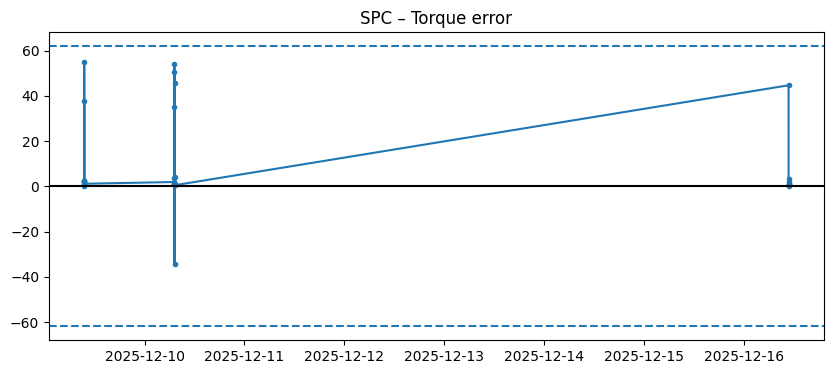

In [9]:
example_proc = spc_stats.index[0]
mask = (df_spc[PROCESS_COLS] == pd.Series(example_proc, index=PROCESS_COLS)).all(axis=1)

d = df_spc.loc[mask].sort_values("RES_DateTime")

plt.figure(figsize=(10,4))
plt.plot(d["RES_DateTime"], d["torque_error"], marker=".", linestyle="-")
plt.axhline(0, color="black")
plt.axhline(3*d["torque_error"].std(), linestyle="--")
plt.axhline(-3*d["torque_error"].std(), linestyle="--")
plt.title("SPC – Torque error")
plt.show()


In [10]:
def out_of_control_rate(x):
    s = x.std()
    return ((x > 3*s) | (x < -3*s)).mean()

ooc = (
    df_spc
    .groupby(PROCESS_COLS)["torque_error"]
    .apply(out_of_control_rate)
    .reset_index(name="ooc_rate")
    .sort_values("ooc_rate", ascending=False)
)

ooc.head(10)


,PS_Number,Tool_ID,TorqueTarget,ooc_rate
7,1,81123704,4.0,1.0
34,3,81123704,8.0,1.0
6,1,81123693,4.0,1.0
11,2,81123572,0.0,1.0
20,2,81123704,5.0,1.0
21,2,81123715,5.0,1.0
23,2,81123726,5.0,1.0
19,2,81123693,5.0,1.0
33,3,81123693,8.0,1.0
35,3,81123715,8.0,1.0
